In [4]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchvision.models import efficientnet_b0
from torchsummary import summary
from sklearn.metrics import classification_report, accuracy_score
import os, shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Callable, Tuple, Any
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
path_to_download: str = "datasets/"
dataset_path: str = path_to_download + "ogyeiv2/ogyeiv2"

## Скачаем данные

In [3]:
# Скачиваем данные
path = kagglehub.dataset_download("richardradli/ogyeiv2")
destination = shutil.copytree(path, path_to_download, dirs_exist_ok=True)
print("Path to dataset files:", destination)

100%|██████████| 3.24G/3.24G [01:42<00:00, 33.8MB/s]

Extracting files...


Path to dataset files: datasets/


# **1. Загрузка и предобработка данных**

**Результаты этапа**

- Готовые для обучения датасеты с предобработкой, загруженные в DataLoader.

- Количество классов, изображений в обучающем и валидационном датасетах.

## Разработаем стандартную трансформацию данных

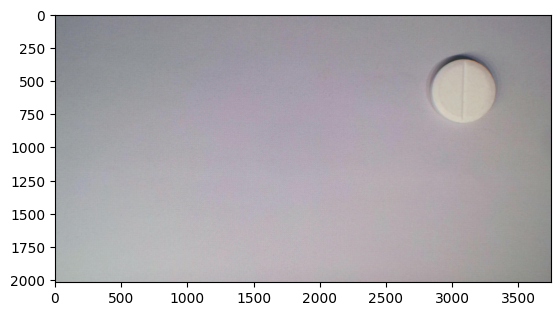

In [4]:
image = Image.open(dataset_path + "/train/images/acc_long_600_mg_s_025.jpg")
plt.imshow(image)

## Константы для трансформации изображений 

In [6]:
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

In [6]:
train_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
])

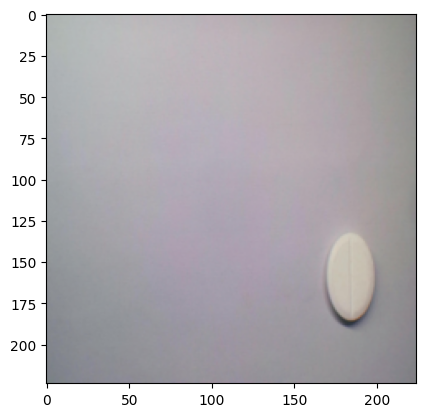

In [7]:
transformed_image = train_transform(image)
plt.imshow(transformed_image)

## Итоговые трансформации 
Для тестового, валидационного и тренировочного наборов данных:

In [7]:
train_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True), 
    T.Normalize(mean = mean, std = std)
])

In [8]:
test_valid_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True), 
    T.Normalize(mean = mean, std = std)
])

## Создадим класс Dataset

In [9]:
# Создадим класс Dataset
torch.manual_seed(2026)

class PillsDataset(Dataset):
    """
    PyTorch Dataset для задачи классификации изображений из структурированной папки.

    Структура директории:
        dataset_root/
            ├── train/
            │   ├── classA_xxx.jpg
            │   ├── classB_yyy.jpg
            │   └── ...
            ├── valid/
            └── test/

    Имя файла содержит метку класса в первой части до первого символа '_',
    например: `naprosyn_250_mg_s_028.jpg` → класс = `"naprosyn"`.

    Args:
        image_paths (List[Path]): Список путей ко всем изображениям в выбранной подпапке.
        labels (List[str]): Список меток классов (в виде строк) для каждого изображения.
        classes (List[str]): Список уникальных классов в порядке сортировки.
        class_to_idx (Dict[str, int]): Отображение класс → индекс (число от 0 до num_classes-1).
        class_counts (Dict[str, int]): Словарь: класс → количество изображений в нём.
        data (Dict[Path, str]): Словарь: путь к файлу → строковая метка класса.
        transform (Optional[Callable]): Функция предобработки изображений (например, torchvision.transforms.Compose).
    """

    def __init__(
        self,
        dataset_root: str,
        split: str,
        transform: Optional[Callable[[Any], torch.Tensor]] = None,
    ) -> None:
        """
        Инициализирует датасет.

        Args:
            dataset_root (str): Путь к корневой директории датасета.
            split (str): Подмножество данных — должно быть одним из {'train', 'valid', 'test'}.
            transform (Optional[Callable]): Преобразование изображения (например, нормализация, ресайз и т.д.).

        Raises:
            ValueError: Если `split` не входит в допустимый набор.
            FileNotFoundError: Если указанная подпапка не существует.
            ValueError: Если не удалась трансформация
        """
        if split not in {"train", "valid", "test"}:
            raise ValueError(f"split must be 'train', 'valid', or 'test', got '{split}'")

        self.split = split
        self._images= "images"
        self.dataset_root = Path(dataset_root)
        split_dir = self.dataset_root / split / self._images

        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        # Сбор всех изображений и извлечение меток
        self.image_paths: List[Path] = []
        self.labels: List[str] = []
        self.data: Dict[Path, str] = {}

        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

        for file_path in split_dir.iterdir():
            if file_path.suffix.lower() in valid_extensions:
                try:
                    class_label = file_path.stem.split("_")[0]
                except IndexError:
                    raise ValueError(f"Cannot parse class from filename: {file_path.name}")
                self.image_paths.append(file_path)
                self.labels.append(class_label)
                self.data[file_path] = class_label

        if not self.image_paths:
            raise ValueError(f"No valid images found in {split_dir}")

        unique_classes = sorted(set(self.labels))
        self.classes: List[str] = unique_classes
        self.class_to_idx: Dict[str, int] = {cls: i for i, cls in enumerate(unique_classes)}

        # Подсчёт количества изображений на класс
        self.class_counts: Dict[str, int] = {cls: 0 for cls in unique_classes}
        for label in self.labels:
            self.class_counts[label] += 1

        # Сохраняем transform
        self.transform = transform

    def __len__(self) -> int:
        """Возвращает общее количество изображений в датасете."""
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Returns:
            Tuple[torch.Tensor, int]: Изображение как тензор и целочисленная метка класса.

        Raises:
            IOError: Если изображение не может быть загружено.
        """
        img_path = self.image_paths[idx]
        label_str = self.labels[idx]
        label_idx = self.class_to_idx[label_str]

        # Загрузка изображения
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise IOError(f"Failed to load image {img_path}: {e}")

        # Применение трансформаций
        if self.transform is not None:
            image = self.transform(image)
        else:
            raise ValueError(f"Failed to transform image {img_path}")

        return image, label_idx

## Создадим наборы данных и проанализируем баланс классов

In [10]:
train_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="train",
    transform = train_transform
)
test_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="test",
    transform=test_valid_transform
)
valid_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="valid",
    transform=test_valid_transform
)

## Балансы классов

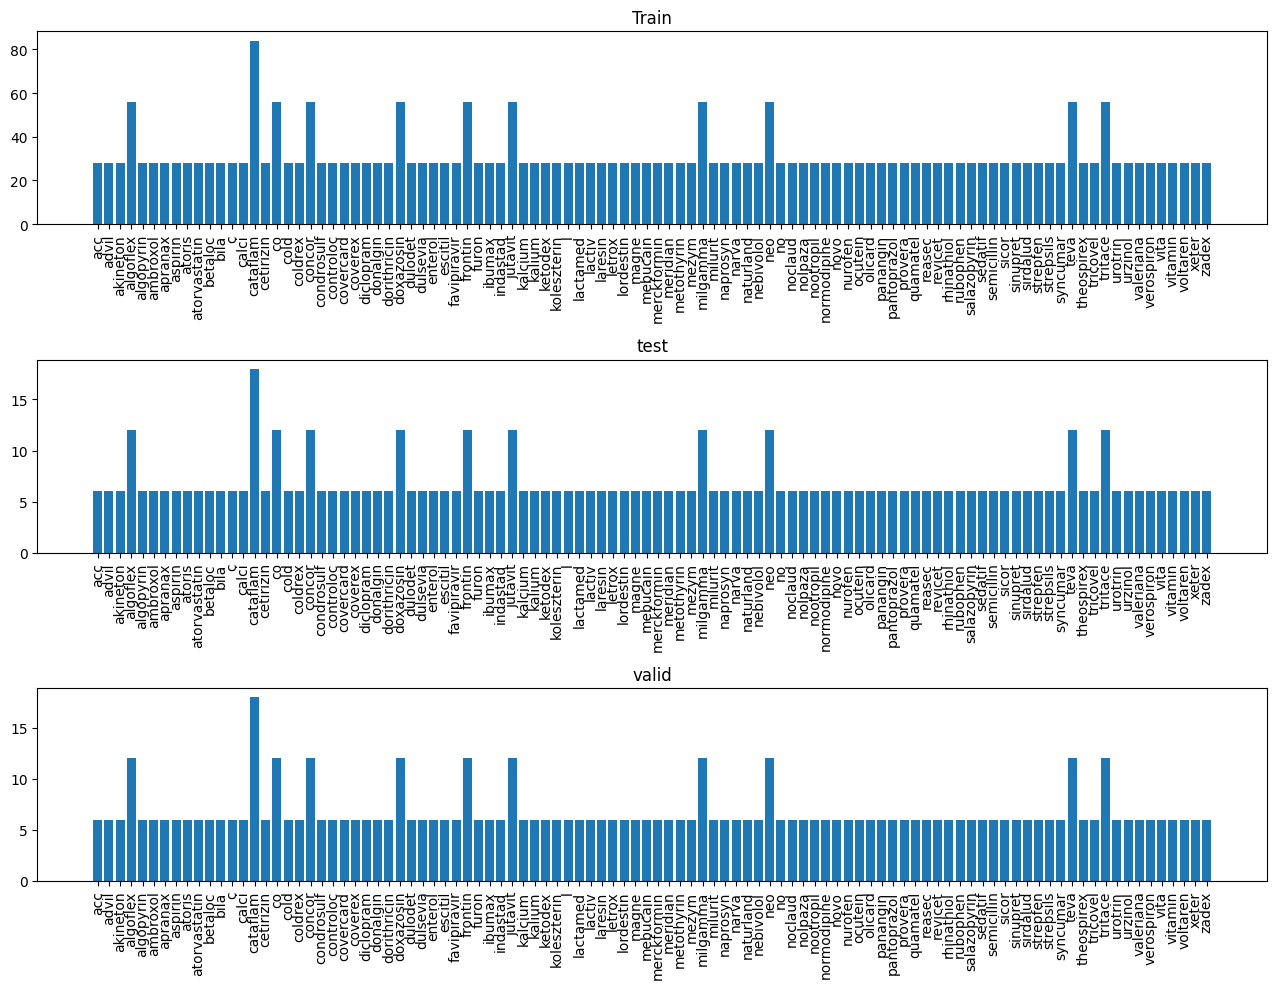

In [ ]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(13, 10)
)
# test
axes[0].bar(
    x=train_dataset.class_counts.keys(), 
    height=train_dataset.class_counts.values())
axes[0].set_title("Train")
ticks = range(len(train_dataset.class_counts.keys()))
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(train_dataset.class_counts.keys(), rotation = 90)

# train

axes[1].bar(
    x=test_dataset.class_counts.keys(), 
    height=test_dataset.class_counts.values())
axes[1].set_title("Test")
ticks = range(len(test_dataset.class_counts.keys()))
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(test_dataset.class_counts.keys(), rotation = 90)

# valid

axes[2].bar(
    x=valid_dataset.class_counts.keys(), 
    height=valid_dataset.class_counts.values())
axes[2].set_title("Valid")
ticks = range(len(valid_dataset.class_counts.keys()))
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(valid_dataset.class_counts.keys(), rotation = 90)

plt.tight_layout()
plt.show()

## Число классов

In [13]:
num_classes = len(train_dataset.classes)
num_classes

100

## Создадим DataLoader

In [16]:
batch_size = 64

In [17]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=batch_size, 
    shuffle=False)


# 2. Обявление модели

Создать классификатор изображений, подходящий для классификации таблеток. Воспользуемся  Transfer Learning. Итоговый классификатор, готовый к обучению или дообучению, поместим в переменную model.

Поскольку стоит задача дообучить систему распознавания, которая будет работать в условиях производственной линии, где необходима точность распознавания и быстродействие, выбор пал на EfficientNet, которую будем дообучать на нашем наборе данных.

In [34]:
model = efficientnet_b0(weights="IMAGENET1K_V1")

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Заменим последний слой на возврат 100 логитов: 

In [35]:
model.classifier[1] = nn.Linear(
    in_features=1280,
    out_features=100,
    bias=True)

summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 112, 112]             864
       BatchNorm2d-2         [64, 32, 112, 112]              64
              SiLU-3         [64, 32, 112, 112]               0
            Conv2d-4         [64, 32, 112, 112]             288
       BatchNorm2d-5         [64, 32, 112, 112]              64
              SiLU-6         [64, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [64, 32, 1, 1]               0
            Conv2d-8              [64, 8, 1, 1]             264
              SiLU-9              [64, 8, 1, 1]               0
           Conv2d-10             [64, 32, 1, 1]             288
          Sigmoid-11             [64, 32, 1, 1]               0
SqueezeExcitation-12         [64, 32, 112, 112]               0
           Conv2d-13         [64, 16, 112, 112]             512
      BatchNorm2d-14         [64, 16, 1

Разморозим последние 2 блока для дообучения и, конечно, классификатор:

In [36]:
for param in model.features[:-2].parameters():  # первые 5 блоков — заморожены
    param.requires_grad = False

for param in model.features[-2:].parameters():  # последние 2 блока — обучаемые
    param.requires_grad = True

# Классификатор — обучаемый
for param in model.classifier.parameters():
    param.requires_grad = True

Так мы сможем с большей уверенностью утверждать, что удасться изъять некоторые тонкости из изображений каждой таблетки, поскольку мы еще будем дообучать последние 2 сверточных блока. Обновление карт признаков на поздних этапах важна для нашей задачи, т.к. распознавание таблеток крайне специфическая тема.

In [37]:
summary(model, (3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 112, 112]             864
       BatchNorm2d-2         [64, 32, 112, 112]              64
              SiLU-3         [64, 32, 112, 112]               0
            Conv2d-4         [64, 32, 112, 112]             288
       BatchNorm2d-5         [64, 32, 112, 112]              64
              SiLU-6         [64, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [64, 32, 1, 1]               0
            Conv2d-8              [64, 8, 1, 1]             264
              SiLU-9              [64, 8, 1, 1]               0
           Conv2d-10             [64, 32, 1, 1]             288
          Sigmoid-11             [64, 32, 1, 1]               0
SqueezeExcitation-12         [64, 32, 112, 112]               0
           Conv2d-13         [64, 16, 112, 112]             512
      BatchNorm2d-14         [64, 16, 1

# 3. Дообучение

In [ ]:
# Функция для тренировки модели с выводом статистик
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    criterion: nn.Module,
    num_epochs: int = 30,
    target_accuracy: float = 0.75,
    checkpoint_dir: str = "checkpoints",
    final_model_path: str = "meds_classifier.pt",
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Обучает модель с логированием, чекпоинтами и ранней остановкой по точности.

    Args:
        model: Обучаемая модель
        train_loader: DataLoader для тренировки
        valid_loader: DataLoader для валидации
        optimizer: Оптимизатор
        scheduler: Планировщик LR
        criterion: Функция потерь
        num_epochs: Макс. число эпох
        target_accuracy: Целевая точность (от 0.0 до 1.0)
        checkpoint_dir: Папка для чекпоинтов
        final_model_path: Путь к финальной модели
        device: Устройство (cuda/cpu)
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch}/{num_epochs}")
        print('='*50)

        # --- Обучение ---
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        pbar = tqdm(train_loader, desc="Train", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu()
            train_preds.extend(preds.tolist())
            train_targets.extend(labels.cpu().tolist())

            pbar.set_postfix({"loss": loss.item()})

        train_acc = accuracy_score(train_targets, train_preds)
        avg_train_loss = train_loss / len(train_loader)

        # --- Валидация ---
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Valid", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.argmax(dim=1).cpu()
                val_preds.extend(preds.tolist())
                val_targets.extend(labels.cpu().tolist())

        val_acc = accuracy_score(val_targets, val_preds)
        avg_val_loss = val_loss / len(valid_loader)

        # Обновление LR
        scheduler.step(avg_val_loss)

        # --- Вывод эпохи ---
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Valid Loss: {avg_val_loss:.4f} | Valid Acc: {val_acc:.4f}")

        # --- Чекпоинт каждые 10 эпох ---
        if epoch % 10 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_loss': avg_val_loss
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        # --- Ранняя остановка по точности ---
        if val_acc >= target_accuracy:
            print(f"\nДостигнута целевая точность {target_accuracy:.2%} на валидации!")
            break

    # --- Сохранение финальной модели ---
    torch.save(model.state_dict(), final_model_path)
    print(f"\n Модель сохранена как: {final_model_path}")

In [ ]:
# Скорость обновления градиентов
learning_rate: float = 1e-4

In [ ]:
# Параметры
num_epochs = 30
target_accuracy = 0.75

# Оптимизатор и планировщик 
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=3)
criterion = nn.CrossEntropyLoss()

# Запуск обучения
train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    target_accuracy=target_accuracy,
    checkpoint_dir="checkpoints",
    final_model_path="meds_classifier.pt",
    device=device
)


Epoch 1/30


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Train Loss: 4.5354 | Train Acc: 0.0293
Valid Loss: 4.4024 | Valid Acc: 0.0938

Epoch 2/30


Train Loss: 4.2516 | Train Acc: 0.1046
Valid Loss: 4.0400 | Valid Acc: 0.1592

Epoch 3/30


Train Loss: 3.9223 | Train Acc: 0.1783
Valid Loss: 3.6346 | Valid Acc: 0.2574

Epoch 4/30


Train Loss: 3.5343 | Train Acc: 0.2943
Valid Loss: 3.2093 | Valid Acc: 0.3631

Epoch 5/30


Train Loss: 3.1466 | Train Acc: 0.3913
Valid Loss: 2.8100 | Valid Acc: 0.4330

Epoch 6/30


Train Loss: 2.7831 | Train Acc: 0.4668
Valid Loss: 2.4831 | Valid Acc: 0.5030

Epoch 7/30


Train Loss: 2.4614 | Train Acc: 0.5166
Valid Loss: 2.1972 | Valid Acc: 0.5551

Epoch 8/30


Train Loss: 2.1954 | Train Acc: 0.5724
Valid Loss: 1.9363 | Valid Acc: 0.5997

Epoch 9/30


Train Loss: 1.9591 | Train Acc: 0.6282
Valid Loss: 1.7418 | Valid Acc: 0.6190

Epoch 10/30


Train Loss: 1.7414 | Train Acc: 0.6674
Valid Loss: 1.5427 | Valid Acc: 0.6696
Checkpoint saved: checkpoints/checkpoint_epoch_10.pth

Epoch 11/30


Train Loss: 1.5918 | Train Acc: 0.6846
Valid Loss: 1.4089 | Valid Acc: 0.6845

Epoch 12/30


Train Loss: 1.4270 | Train Acc: 0.7248
Valid Loss: 1.2672 | Valid Acc: 0.7321

Epoch 13/30


Train Loss: 1.3244 | Train Acc: 0.7452
Valid Loss: 1.1694 | Valid Acc: 0.7396

Epoch 14/30


Train Loss: 1.1986 | Train Acc: 0.7615
Valid Loss: 1.0565 | Valid Acc: 0.7515

Достигнута целевая точность 75.00% на валидации!

 Модель сохранена как: meds_classifier.pt


**Результаты этапа**

- Распечатка ошибок на обучающем и тестовом датасетах в конце каждой эпохи.
- Файл с моделью meds_classifier.pt.

# 4. Оценка качества

In [ ]:
# Функция для получения предсказаний модели на тестовой выборке
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    return all_labels, all_preds

**Распечатаем classification_report**

In [42]:
y_true, y_pred = evaluate_model(model, test_loader, device)
print(classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=0))

              precision    recall  f1-score   support

         acc       1.00      1.00      1.00         6
       advil       1.00      1.00      1.00         6
    akineton       0.71      0.83      0.77         6
    algoflex       1.00      1.00      1.00        12
   algopyrin       0.86      1.00      0.92         6
    ambroxol       0.80      0.67      0.73         6
     apranax       0.86      1.00      0.92         6
     aspirin       0.67      0.67      0.67         6
      atoris       0.67      1.00      0.80         6
atorvastatin       0.60      0.50      0.55         6
     betaloc       1.00      0.83      0.91         6
        bila       1.00      0.83      0.91         6
           c       1.00      1.00      1.00         6
       calci       1.00      1.00      1.00         6
    cataflam       0.79      0.83      0.81        18
   cetirizin       0.75      1.00      0.86         6
          co       0.42      0.42      0.42        12
        cold       1.00    

Выведем confusion_matrix для самых путаемых классов:

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Полная confusion matrix
cm_full = confusion_matrix(y_true, y_pred, normalize=None)

# 2. Число ошибок по каждому классу = сумма всех кроме диагонали
n_classes = cm_full.shape[0]
errors_per_class = cm_full.sum(axis=1) - np.diag(cm_full) 

# 3. Выбрать 30 классов с наибольшими ошибками
top_30_classes = np.argsort(errors_per_class)[-30:][::-1] 

# 4. Извлечь подматрицу 30x30
cm_30 = cm_full[np.ix_(top_30_classes, top_30_classes)]

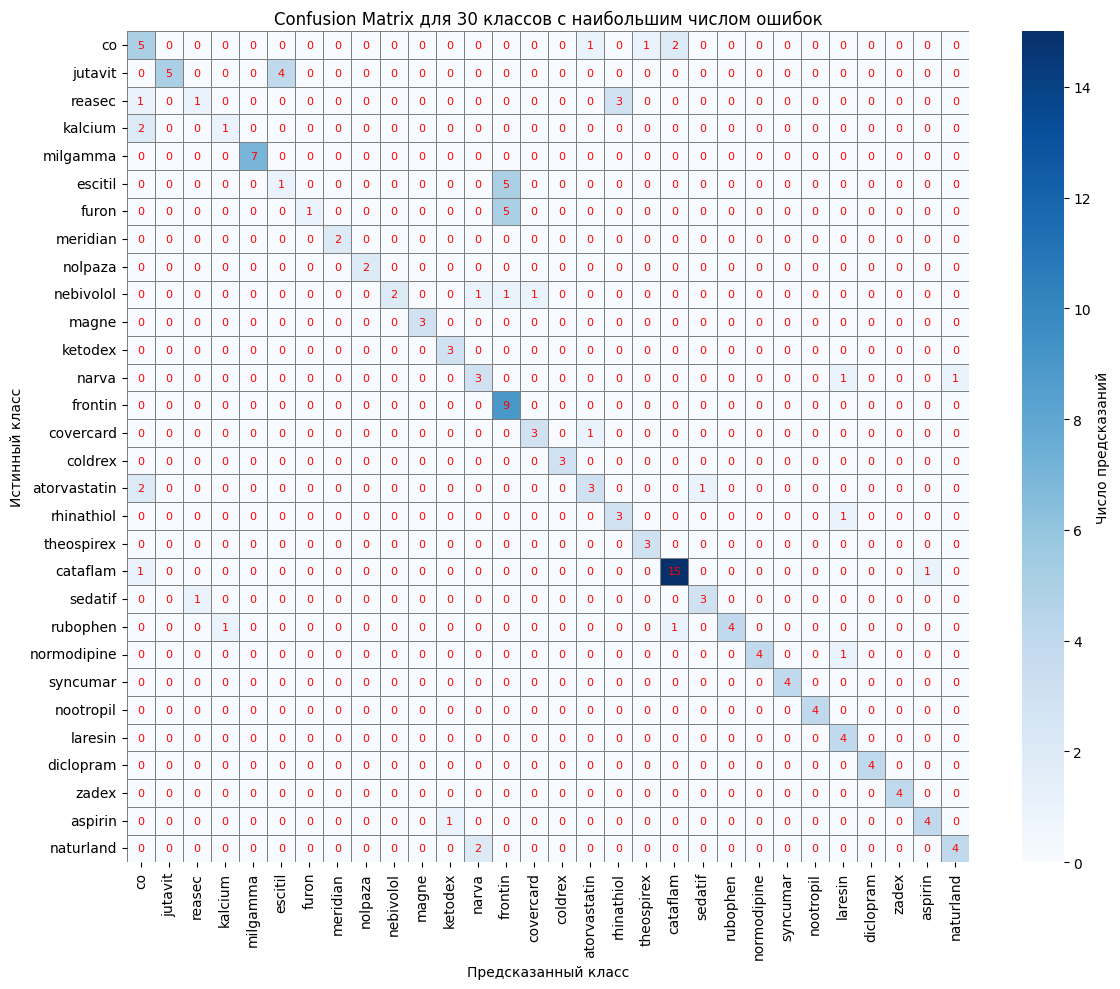

In [46]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_30,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[test_dataset.classes[i] for i in top_30_classes],
    yticklabels=[test_dataset.classes[i] for i in top_30_classes],
    cbar_kws={'label': 'Число предсказаний'},
    annot_kws={'color': 'red', 'size': 8},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Confusion Matrix для 30 классов с наибольшим числом ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.tight_layout()
plt.show()

Функци ниже понадобяться нам для анализа

In [30]:
def find_one_sample_per_class(dataset, class_names):
    """Возвращает список (изображение_tensor, метка) для каждого класса из class_names."""
    samples = []
    used_paths = set()
    for cls in class_names:
        for img_path, label in dataset.data.items():
            if label == cls and img_path not in used_paths:
                image, _ = dataset[dataset.image_paths.index(img_path)]
                samples.append((image, cls))
                used_paths.add(img_path)
                break
    return samples

In [ ]:
def find_sample_by_class(dataset, class_name, exclude_idx=None):
    """Возвращает (изображение_tensor, путь) для первого найденного изображения класса."""
    for i, (img_path, label) in enumerate(dataset.data.items()):
        if label == class_name and (exclude_idx is None or i != exclude_idx):
            image, _ = dataset[i] 
            return image, img_path
    return None, None

**Результаты этапа**

- Распечатка Precision, Recall, F1 для каждого класса + общая accuracy для классификатора таблеток с accuracy выше 75%.
- Текст с ответами на вопросы:
    - На каких 5 классах модель ошибается чаще всего?
    - Почему модель может ошибаться на этих классах?
    - На каких классах модель не совершает ошибок?
    - Почему эти классы модель распознаёт безошибочно?
    - Как можно улучшить точность классификатора?
    - Как ещё можно проанализировать результаты и ошибки модели?

Ответы на вопросы.

**1. На каких 5 классах модель ошибается чаще всего?**

In [ ]:
# 1. Выбрать 5 классов с наибольшими ошибками
top_5_classes = np.argsort(errors_per_class)[-5:][::-1] 

print([test_dataset.classes[i] for i in top_5_classes])

['co', 'jutavit', 'reasec', 'kalcium', 'milgamma']


**2. Почему модель может ошибаться на этих классах?**

Для анализа, выведем 5 блоков изображений.

В каждом блоке будет 1 - изображение истинного класса и изображения классов с которыми модель путает наш класс.

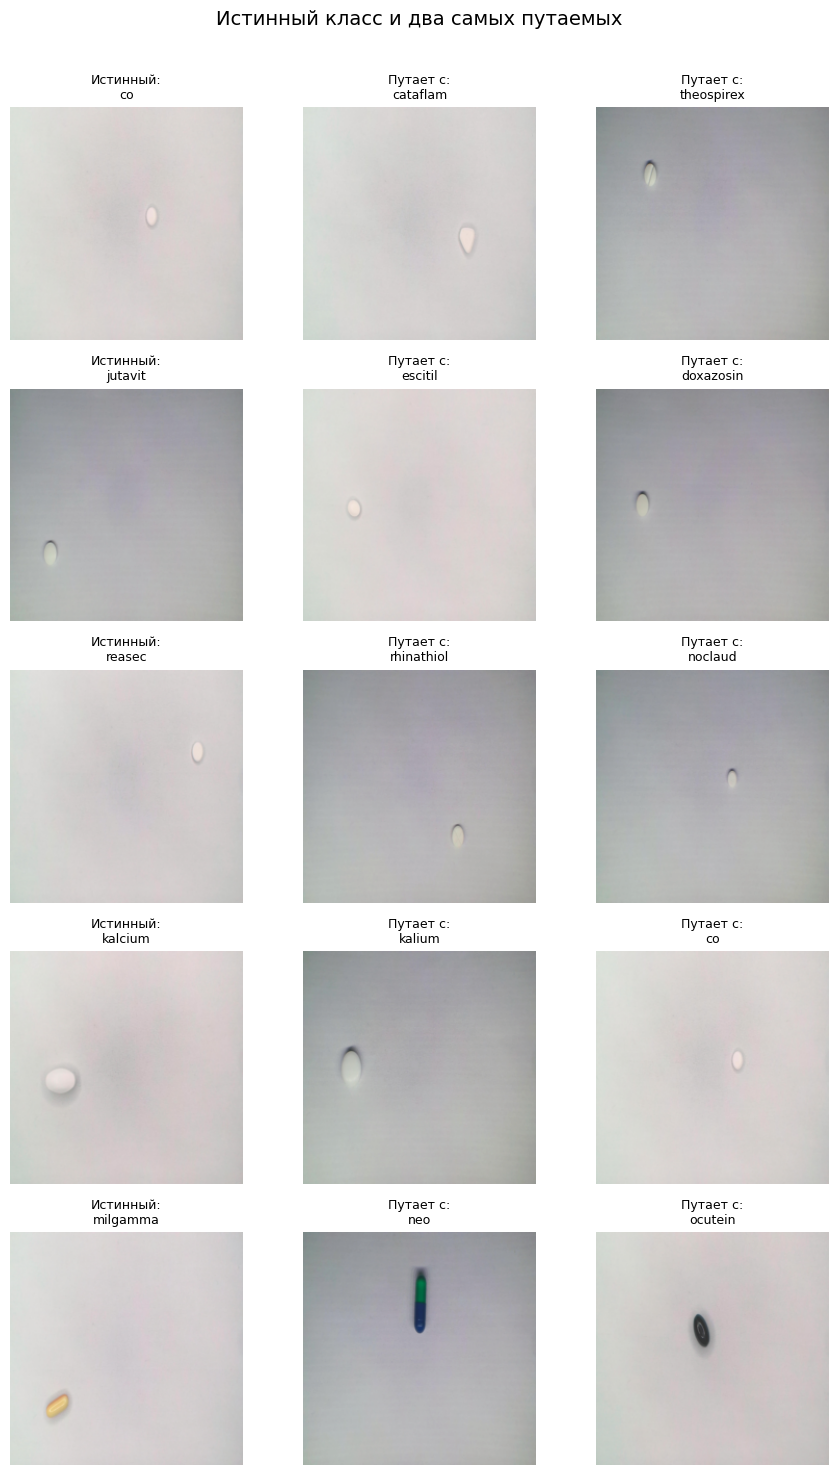

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as T

# Для обратной нормировки (если использовали Normalize)
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_image(ax, img_tensor, title, true_label=None, pred_label=None):
    img = inv_normalize(img_tensor) if img_tensor is not None else None
    img = torch.clamp(img, 0, 1)  # обрезаем значения
    ax.imshow(to_pil_image(img))
    ax.set_title(title, fontsize=9)
    ax.axis('off')

# Настройка
target_classes = top_5_classes
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

fig, axes = plt.subplots(5, 3, figsize=(9, 15))
fig.suptitle("Истинный класс и два самых путаемых", fontsize=14)

for row, true_class in enumerate(target_classes):
    if true_class not in class_to_idx:
        print(f"Класс {true_class} отсутствует в датасете")
        continue

    true_idx = class_to_idx[true_class]
    # Исключаем диагональ (правильные предсказания)
    errors = cm_full[true_idx].copy()
    errors[true_idx] = 0  # игнорируем правильные

    # Находим два класса с наибольшими ошибками
    top_error_indices = np.argsort(errors)[-2:][::-1]  # последние два, в порядке убывания
    confused_classes = [idx_to_class[idx] for idx in top_error_indices if errors[idx] > 0]

    # Достаём изображения
    true_img, _ = find_sample_by_class(test_dataset, true_class)

    # Выводим истинный класс
    show_image(axes[row, 0], true_img, f"Истинный:\n{true_class}")

    # Выводим путаемые
    for col in range(2):
        if col < len(confused_classes):
            confused_class = confused_classes[col]
            confused_img, _ = find_sample_by_class(test_dataset, confused_class)
            show_image(axes[row, 1 + col], confused_img, f"Путает с:\n{confused_class}")
        else:
            axes[row, 1 + col].axis('off')  # если нет второго путаемого

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Если обратить внимание на первые четыре ряда изображений можно заметить как трудно их визуально отличить друг от друга. Эти таблетки практически идентичны. По поводу последнего примера можно заключить, что модель не достаточно хорошо научилась анализировать мелкие признаки на таблетках нестандартной формы.

**3. На каких классах модель не совершает ошибок?**


Согласно classification_report хорошая оценка у модели для многих классов. Попробуем вывести их изображения все:

In [34]:
class_names = test_dataset.classes
report_dict = classification_report(
    y_true, 
    y_pred,
    target_names=class_names, 
    output_dict=True, 
    zero_division=0)

In [36]:
# Исключим общие метрики ('accuracy', 'macro avg', и т.д.)
class_metrics = {k: v for k, v in report_dict.items() if k not in {'accuracy', 'macro avg', 'weighted avg'}}

# Рейтинг по F1-score (или можно по min(precision, recall))
sorted_classes = sorted(
    class_metrics.items(),
    key=lambda item: item[1]['f1-score'],
    reverse=True
)

# Возьмём топ-5
top_6_unconfused = [cls for cls, _ in sorted_classes[:6]]
print("Самые не путаемые классы:", top_6_unconfused)

Самые не путаемые классы: ['acc', 'advil', 'algoflex', 'c', 'calci', 'cold']


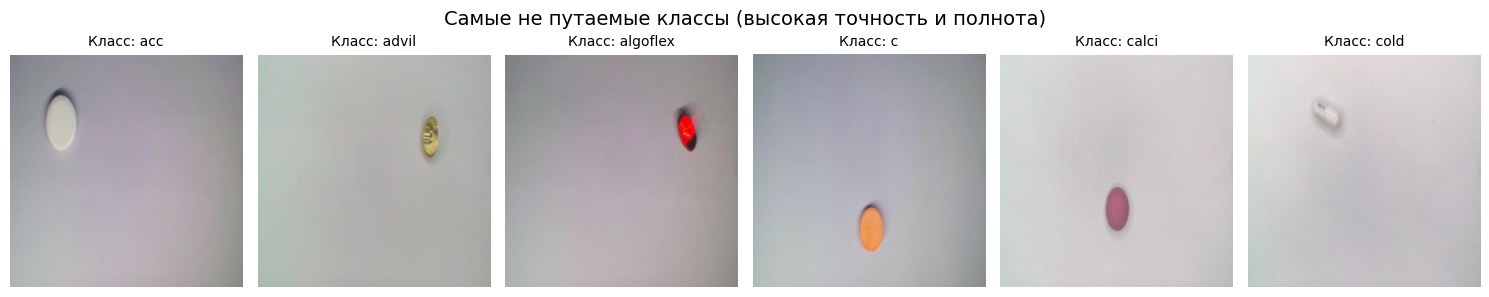

In [38]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as T

# Получаем изображения
top_samples = find_one_sample_per_class(test_dataset, top_6_unconfused)

# Визуализация
fig, axes = plt.subplots(1, len(top_samples), figsize=(15, 3))
fig.suptitle("Самые не путаемые классы (высокая точность и полнота)", fontsize=14)

for ax, (img_tensor, cls_name) in zip(axes, top_samples):
    img = inv_normalize(img_tensor)
    img = torch.clamp(img, 0, 1)
    ax.imshow(to_pil_image(img))
    ax.set_title(f"Класс: {cls_name}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

**4. Почему эти классы модель распознаёт безошибочно?**

В данной ситуации, могу предположить, что эти классы имеют ярко выраженные особенности - цвет, текстура, форма, размеры. Если взглянуть на те классы, на которых модель чаще ошибается, можно заключить, что это не далеко от правды, ведь плохо различимые классы едва-едва можно визуально отличить друг от друга.

**5. Как можно улучшить точность классификатора?**

Поскольку ключевым является особенность в мелких деталях и мелких формах, я бы предложил два варианта для решения этой задачи.
1) Попробовать пообучать дольше. Возможно с тем подбором, который сейчас есть можно достигнуть точности около 90%.
2) В связи с тем, что на всех изображениях таблетка распологается в какой-то части, мы получаем лишнюю информацию в виде шума для фона. Т.к. изображения из источника поступают в достаточно хорошем качестве, я бы попробовал использовать модель детекции - для обнаружения рамки, в которой точно располагается таблетка. Я думаю высокого качества в данном случае можно будет достичь без особых затрат ресурсов. Далее я бы обрезал изображения по этой рамке и использовал модель, которая будет анализировать таблетку "целиком" что позволит изымать наиболее мелкие детали, различия.
3) Дообучать модель на плохо различимых классах, собирать по ним больше данных, анализировать, возможно, разморозить еще пару нижних слоев модели.

**6. Как ещё можно проанализировать результаты и ошибки модели?**

- Построить диаграммы распределения частых ошибок по классам.
- Проанализировать дополнительные метаданные - производитель, грамовка, размер таблетки.
- Построить гистограмму вероятностей по softmax на логитах модели. В данном случае при низких вероятностях можно будет настроить "отказ от ответа". В таких ситуациях система будет звать человека для принятия решения.